In [1]:
import pandas as pd
import re

csv_path = 'Output/Results.csv'
readme_path = 'README.md'

df = pd.read_csv(csv_path)
cols_drop = ['Kappa', 'Time']
df = df.drop(columns=[c for c in cols_drop if c in df.columns])
md_table = df.to_markdown(index=False)

start_tag = '<!-- CSV_TABLE_START-->'
end_tag = '<!-- CSV_TABLE_END-->'

with open(readme_path, 'r', encoding='utf-8') as f:
    readme = f.read()

pattern = re.compile(f'{start_tag}.*?{end_tag}', re.DOTALL)
replacement = f'{start_tag}\n\n{md_table}\n\n{end_tag}'

if re.search(pattern, readme):
    new_readme = re.sub(pattern, replacement, readme)
else:
    new_readme = readme.strip() + '\n\n ## Data Summary\n' + replacement


with open('README.md', 'w', encoding='utf-8') as f:
    f.write(new_readme)

In [18]:
import pandas as pd
import re
from html import escape

csv_path = 'Output/Results.csv'
readme_path = 'README.md'

df = pd.read_csv(csv_path)

# 不要列を削除（存在チェック付き）
cols_to_drop = ["Kappa", "Time"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# View列の連続同値グループを計算
views = df['View'].astype(str).tolist()
group_sizes = []
group_start_idxs = []
if views:
    cur = views[0]
    cnt = 1
    start = 0
    for i, v in enumerate(views[1:], start=1):
        if v == cur:
            cnt += 1
        else:
            group_sizes.append(cnt)
            group_start_idxs.append(start)
            cur = v
            cnt = 1
            start = i
    group_sizes.append(cnt)
    group_start_idxs.append(start)
else:
    group_sizes = []
    group_start_idxs = []

# HTMLテーブルを作る
cols = df.columns.tolist()
html = ['<table>', '  <thead>', '    <tr>']
for c in cols:
    html.append(f'      <th>{escape(c)}</th>')
html.append('    </tr>')
html.append('  </thead>')
html.append('  <tbody>')

# 行ごとに出力。ただし group の先頭行でのみ View 列を <td rowspan="n"> にする
group_map = {}  # row_index -> rowspan (only for start rows)
for size, start in zip(group_sizes, group_start_idxs):
    group_map[start] = size

for i, row in df.iterrows():
    html.append('    <tr>')
    # View 列は先頭行で rowspan を付け、それ以外はスキップ（つまりセルを書かない）
    if i in group_map:
        rowspan = group_map[i]
        view_val = escape(str(row['View']))
        html.append(f'      <td rowspan="{rowspan}">{view_val}</td>')
    # 列全体を書き出すが、View は既に処理したのでスキップして続ける
    for c in cols:
        if c == 'View':
            continue
        val = '' if pd.isna(row[c]) else escape(str(row[c]))
        html.append(f'      <td>{val}</td>')
    html.append('    </tr>')

html.append('  </tbody>')
html.append('</table>')

html_table = '\n'.join(html)

# README に差し替え
start_tag = '<!-- CSV_TABLE_START-->'
end_tag = '<!-- CSV_TABLE_END-->'

with open(readme_path, 'r', encoding='utf-8') as f:
    readme = f.read()

pattern = re.compile(f'{start_tag}.*?{end_tag}', re.DOTALL)
replacement = f'{start_tag}\n\n{html_table}\n\n{end_tag}'

if re.search(pattern, readme):
    new_readme = re.sub(pattern, replacement, readme)
else:
    new_readme = readme.strip() + '\n\n ## Data Summary\n' + replacement

with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(new_readme)

print("README updated with HTML table (rowspan for consecutive View groups).")


README updated with HTML table (rowspan for consecutive View groups).


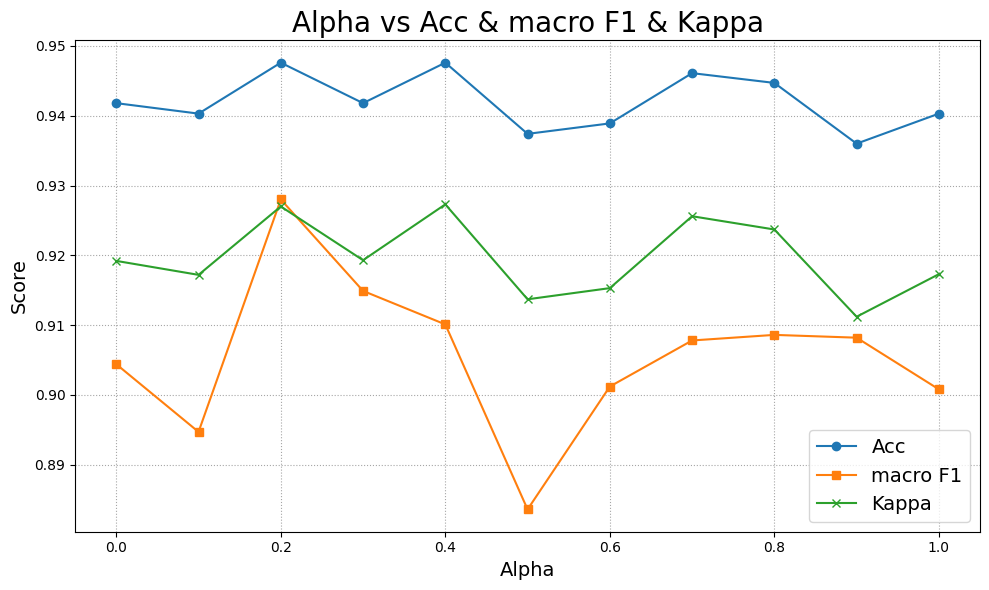

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV ファイルを読み込み
df = pd.read_csv("Output/Top/MidNet/alpha/Comparison.csv")   # ←あなたのCSV名に変更

# ---- Plot 2: Alpha vs Acc / macro F1 ----
plt.figure(figsize=(10,6))
plt.plot(df["Alpha"], df["Acc"], label="Acc", marker="o")
plt.plot(df["Alpha"], df["macro F1"], label="macro F1", marker="s")
plt.plot(df["Alpha"], df["Kappa"], label="Kappa", marker="x")
plt.xlabel("Alpha", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Alpha vs Acc & macro F1 & Kappa", fontsize=20)
plt.legend(fontsize=14)
plt.grid(color='gray', alpha=0.7, linestyle=':')
plt.tight_layout()
plt.savefig("Output/Top/MidNet/alpha/Comparison.png")
plt.show()